In [1]:
#Generic Python packages
import gc
import os
import numpy as np
import pandas as pd
#opening and dealing with files
import fitsio
#Coordinate systems
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy.wcs import WCS
#Big Beautiful Plots
import pylab as plt

# LSST Science Pipelines (Stack) Packages
from lsst.rsp import get_tap_service, retrieve_query
from useful_functions_global import *

#for saving plots to my folder
my_path =  '/sdf/data/rubin/user/kexcel/'
my_plotspath = my_path + 'plots/'
#global plot parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Loading in data

#### Q: TAP vs Butler?
For querying DP1 data, I'm using TAP. It's been recommended as the best way for searching on the catalog level. If you do choose to use the Butler, you'd define DP1 as the collection, and the quality flags would be added as columns to then be masked/restricted later. Here, with TAP, to mind the flags, you apply constraints on the query.

In [2]:
#If using the Butler, this will be helpful:
#this is from RubinObs slack, Nacho Sevilla Noarbe sent it but it's maybe from Peter Ferguson and Douglas Tucker
#tract is a large section of the sky, made up of 10x10 patches
tract_dict={453: '47 Tuc',
            454: '47 Tuc',
           4849: 'ECDFS', #Euclid's "Euclid Deep Field Fornax" encompasses Extended Chandra Deep Field South
           5063: 'ECDFS',
           4848: 'ECDFS',
           2394: 'EDFS',
           2234: 'EDFS',
           4016: 'Fornax',
           4017: 'Fornax',
           4218: 'Fornax',
           4217: 'Fornax',
           5525: 'Rubin_SV_095-25',
           5526: 'Rubin_SV_095-25',
           7611: 'Seagull',
           7610: 'Seagull',
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7',
           10464: 'Rubin_SV_38_7',
           10704: 'Rubin_SV_38_7'
           }

In [3]:
service = get_tap_service("tap")
assert service is not None

In [4]:
def querylsst(service, query_cuts, ra, dec, radius=1.0):
    """ Return data queried from Rubin TAP

    Adapted from Kabelo Tsaine's simple_adl/query_TAP.py, edited to work on DP1 syntax

    Parameters
    ----------
    service: str
        TAP service
    ra: float
        Right Ascension [deg]
    dec: float
        Declination [deg]
    radius: float
        Radius around (ra, dec) [deg]

    Returns
    -------
    good_results: DataFrame
    """

    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg

    query = f"""
        SELECT
            coord_ra AS ra, coord_dec AS dec,
            g_extendedness, r_extendedness, i_extendedness, z_extendedness,
            g_SizeExtendedness, r_SizeExtendedness, i_SizeExtendedness, z_SizeExtendedness,
            g_psfFlux, r_psfFlux, i_psfFlux, z_psfFlux,
            g_psfFluxErr, r_psfFluxErr, i_psfFluxErr, z_psfFluxErr,
            g_cModelFlux, r_cModelFlux, i_cModelFlux, z_cModelFlux,
            g_cModelFluxErr, r_cModelFluxErr, i_cModelFluxErr, z_cModelFluxErr
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
                        CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        """ + query_cuts

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    return results

In [5]:
#to offer the most flexibility in which cuts are applied, we construct it outside the function
query_cuts = ""

safe_max_extended = 1.0 #extendedness is supposed to be constructed cut off at 1.0
query_cuts += f"AND g_extendedness <= {str(safe_max_extended)} "
query_cuts +=  "AND detect_isIsolated = 1" #detect_isPrimary is already applied
for band in 'griz':
    #checking that each band has no flux flag
    query_cuts += f"AND {band}_psfFlux_flag = 0"

#I label what field is queried and what cuts have been applied up here
#so that the graph titles later on in the code have accurate labels
cuts = "all"
field = "EDFS" #coordinates for the center of ComCam/DP1 EDFS = 59.10, -48.73

lsst_query = querylsst(service, query_cuts, 59.10, -48.73, radius=2.0)
#I found it was simplest to apply SNR cuts like this
lsst_mask = (lsst_query['r_psfFlux'] / lsst_query['r_psfFluxErr']) > 5
lsst_field = lsst_query[lsst_mask]

#### Q: Where can I find Euclid data?
To the extent of my knowledge, as of 9/26/25, Euclid data has not been uploaded to NERSC. 
On USDF, there are 2 paths I know of:
- Peter Ferguson uploaded all Euclid q1 catalogs and the images (Y, J, H, and VIS) overlapping Euclid Deep Field South here: '/sdf/group/rubin/shared/euclid/'
    - I would just like to cite his notebook on working with Euclid data, I learned a lot from it
- Dan Taranu uploaded ECDFS Euclid VIS/NISP imaging here: '/sdf/data/rubin/user/dtaranu/tickets/cdfs/euclid/'

In [6]:
#coarser resolution to load in euclid files, which follow nside = 64 pixel name convention
nside = 64
lsst_ra = lsst_field['ra']
lsst_dec = lsst_field['dec']
#converting our queried LSST ra and dec into pixels
lsst_pix64 = hp.ang2pix(nside, lsst_ra, lsst_dec, lonlat=True, nest=True)
lsst_upix64 = np.unique(lsst_pix64.values)

euclid_path = "/sdf/group/rubin/shared/euclid/q1/catalogs/"
euclid = []
for pix in lsst_upix64:
    #iterating through the LSST pixels to see which Euclid files coarsely overlap
        #a finer resolution mask will be applied later
    euclid.append(fitsio.read(euclid_path + f"euclid_q1_mer_final_{pix:05d}.fits"))
euclid_fits = np.concatenate(euclid)

Euclid flags, explained in 'Euclid Quick Data Release (Q1), The active galaxies of Euclid' by Matamoro Zatarain et al. 2025:  
- "DET_QUALITY_FLAG values of 0, 2, and 512 indicate no problems with the data, sources blended together, 
and sources within an extended object area, respectively."
- <band>_FLAG = detect contamination in specific bands
- SPURIOUS_FLAG = detect contamination by spurious sources

In [7]:
#now get greater resolution to match up
NSIDE=4096
#get the pixels of LSST data
lsst_upix4096, lsst_cts = np.unique(hp.ang2pix(NSIDE, lsst_ra, lsst_dec, lonlat=True), return_counts=True)
#then get the pixels of Euclid data
euclid_pix4096 = hp.ang2pix(NSIDE, euclid_fits['RIGHT_ASCENSION'], euclid_fits['DECLINATION'], lonlat=True)
#Euclid has more coverage right now. We only keep the sources that lie in the LSST coverage
mask = np.isin(euclid_pix4096, lsst_upix4096) #[lsst_cts > 8])

#SNR cut
mask &= (euclid_fits['FLUX_VIS_PSF'] / euclid_fits['FLUXERR_VIS_PSF'] > 5)
#quality cuts defined above
mask &= (euclid_fits['SPURIOUS_FLAG'] == 0)
mask &= ((euclid_fits['DET_QUALITY_FLAG'] == 0) | (euclid_fits['DET_QUALITY_FLAG'] == 2) | (euclid_fits['DET_QUALITY_FLAG'] == 512))
for band in ['VIS', 'Y', 'J', 'H']:
    mask &= (euclid_fits[f'FLAG_{band}'] == 0)

euclid_field = euclid_fits[mask]
euclid_ra = euclid_field['RIGHT_ASCENSION']
euclid_dec = euclid_field['DECLINATION']

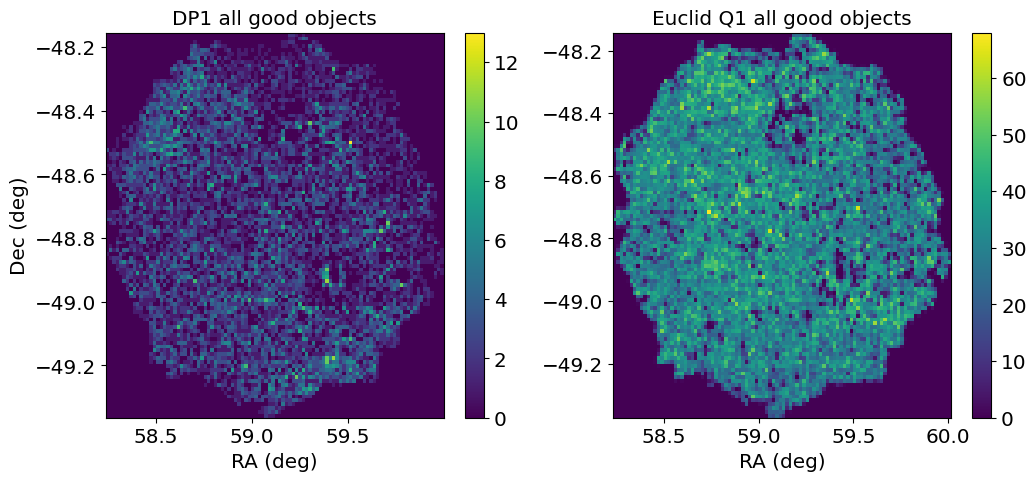

In [8]:
#Verify I matched up the fields correctly
fig, ax = plt.subplots(1,2, figsize=(12,5))

_, _, _, im = ax[0].hist2d(lsst_ra, lsst_dec, bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('DP1 all good objects')
ax[0].set_ylabel("Dec (deg)")
ax[0].set_xlabel("RA (deg)")

_, _, _, im = ax[1].hist2d(euclid_ra, euclid_dec, bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Euclid Q1 all good objects")
ax[1].set_xlabel("RA (deg)")
plt.savefig(my_plotspath + f"DP1_EUCLID_{field}maps_{cuts}mask.png")

#### Q: what are those artifacts? bright stars?
^I haven't answered that question for myself yet

Notes to self, **you can ignore**:
- it looks like the pixel matching is working well to not include euclid sources where comcam has blank artifacts
- artifacts present in plot with no mask, so is it a detector issue? bright foreground object?
    - comcam gets up to >100 sources in pixel w no mask
- even more splotchyness/artifacts when just a g_extendedness < 1 mask applied (what does that mask cut out?)
    - comcam cut down severely, get only to 50 sources in pixel
- detect_isIsolated big cut, takes it down to only max ~18 sources
- band flag mask only do a small cut (max ~16) and the SNR based on r band is a smaller cut too (max ~12)
- Euclid's SNR mask (at least, that mask being applied first) cuts it from 140 -> 80
- applying "euclid_fits['DET_QUALITY_FLAG'] == 0" gets this weird square in Euclid
    - oops! changing it to "(euclid_fits['DET_QUALITY_FLAG'] == 0) | (euclid_fits['DET_QUALITY_FLAG'] == 2) | (euclid_fits['DET_QUALITY_FLAG'] == 512)" fixes that

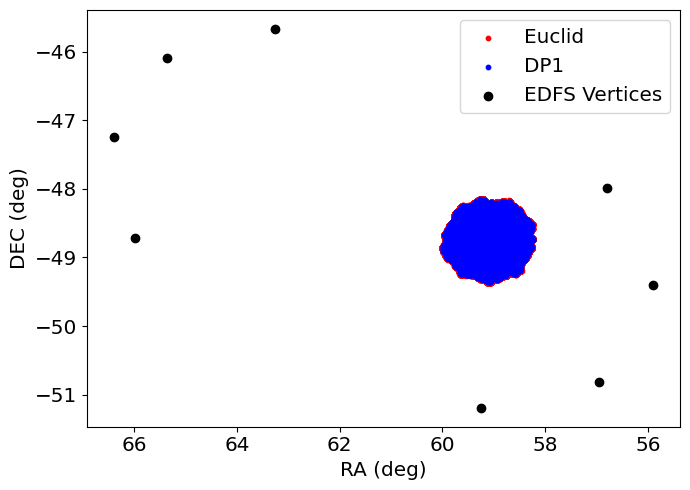

In [9]:
#Another coordinate mask verification
fig, ax = plt.subplots(1,1, figsize=(7,5))

#Define EDFS polygon region (vertices from Euclid documentation)
vertices = np.array([[63.25, -45.67], [65.35, -46.10], [66.40, -47.25],
       [65.99, -48.72], [59.25, -51.19], [56.95, -50.82],
       [55.90, -49.40], [56.80, -47.99]])

ax.scatter(euclid_ra, euclid_dec, s = 10, color='red', label = "Euclid")
ax.scatter(lsst_ra, lsst_dec, s = 10, color = 'blue', label = "DP1")
ax.set(xlabel = "RA (deg)", ylabel = "DEC (deg)")
ax.invert_xaxis()
euclid_center =  SkyCoord('04:04:57.84 -48:25:22.8', unit=(u.hourangle, u.deg), frame = 'icrs')
lsst_center = SkyCoord('59.10 -48.73', unit=(u.deg, u.deg), frame = 'icrs')
#plt.scatter(lsst_center.ra.deg, comcam_center.dec.deg, color = 'red', marker = '*', label = 'DP1 Center')
#plt.scatter(euclid_center.ra.deg, euclid_center.dec.deg, color = 'red', marker = '*', label = 'Euclid Center')
plt.scatter(vertices[:, 0], vertices[:, 1], color = 'k', label = 'EDFS Vertices')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig(my_plotspath + 'context_of_field')

Now, we're going to get a rough sketch of just the stars in each catalog. Euclid defines a "point like probability," which is a gradient from 0.0 to 1.0 where 1.0 is definitely a star and 0.0 definitely a galaxy. 'POINT_LIKE_PROB' is based on peak surface brightness vs integrated surface brightness.
DP1 defines "size extendedness" for each band. i seems to me to be the optimal choice here. (I have not found the documentation where 'SizeExtendedness' calculation is explained, but it's described as a "moments-based calculation")

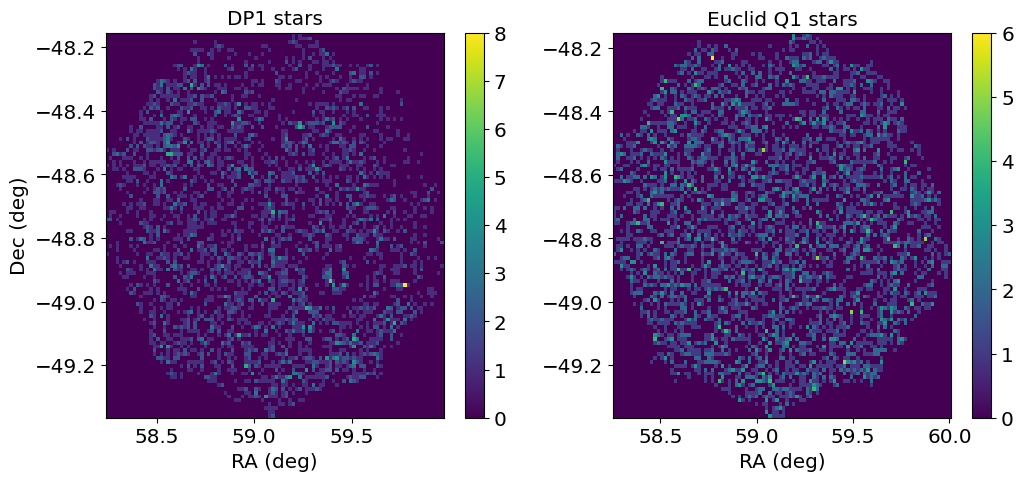

In [10]:
euclid_stars = euclid_field[euclid_field['POINT_LIKE_PROB'] > 0.7]
euclid_stars_ra = euclid_stars['RIGHT_ASCENSION']
euclid_stars_dec = euclid_stars['DECLINATION']

#one possible criterion
stardef = 'i_SizeExtendedness'
lsst_stars = lsst_field[lsst_field['i_SizeExtendedness'] < 0.5]
lsst_stars_ra = lsst_stars['ra']
lsst_stars_dec = lsst_stars['dec']

fig, ax = plt.subplots(1,2, figsize=(12,5))

_, _, _, im = ax[0].hist2d(lsst_stars_ra, lsst_stars_dec, bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('DP1 stars')
ax[0].set_ylabel("Dec (deg)")
ax[0].set_xlabel("RA (deg)")

_, _, _, im = ax[1].hist2d(euclid_stars_ra, euclid_stars_dec, bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Euclid Q1 stars")
ax[1].set_xlabel("RA (deg)")
plt.savefig(my_plotspath + f"stars_DP1_EUCLID_{field}maps_basedon_{stardef}.png")

## Photometry

First! We'll just gain some intuition about what our catalogs' photometry look like. 
1) Graph some star galaxy separation plots (comparing cModel and PSF magnitudes) for each LSST band and then for Euclid's vis band
2) Graph color-mag for what LSST calls a star

#### Q: what's zero-point determined from? -> Rubin measures in nJy. AB system wants 0 mag to be ~ 3631 Jy which is $3.631 \times 10^{12} \rm{nJy}$ $$\\m = -2.5\log_{10}(f_v) + 2.5log_{10}(3.631 \times 10^{12}) = -2.5\log_{10}(f_v) + 31.4$$

#### Q: what's cmodel/physical meaning of psf - cmodel?
cModel = composite model. *insert more here*  

From DP0 documentation: "{band}_cModelFlux is a reasonable choice for galaxy fluxes. PSF model fluxes are generally recommended for point source photometry"
If the source is well fit by the psf flux (i.e. psf mag - cmodel mag is 0) it's point-like and likely a star. the worse it fits the psf model, the more extended it is (more likely to be a galaxy)

/sdf/data/rubin/user/kexcel/useful_functions_global.py:5: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux) + zeropoint


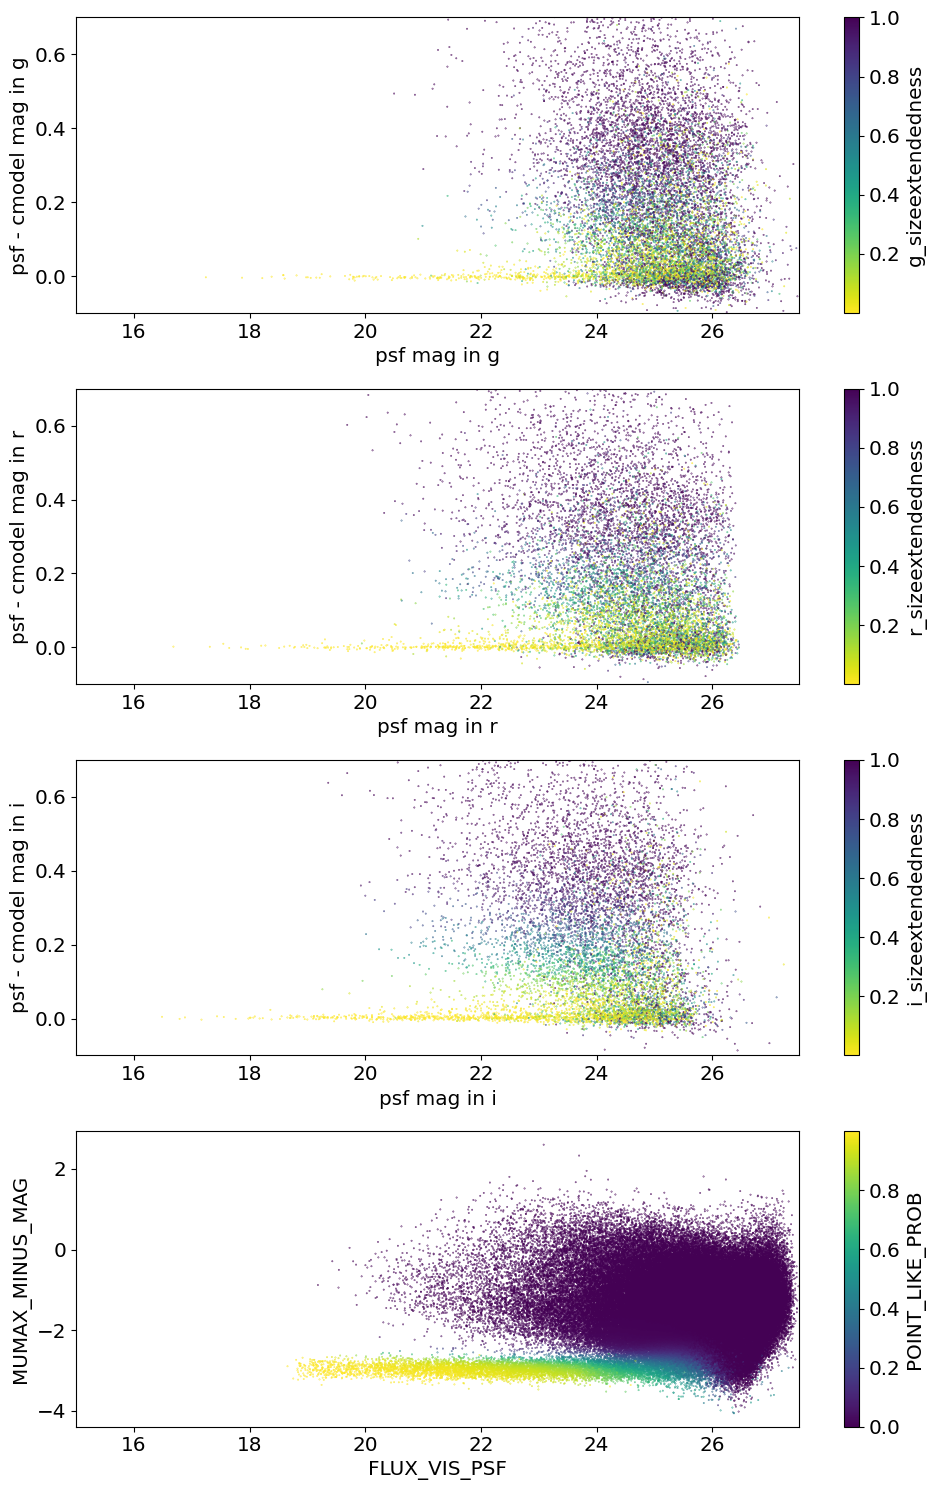

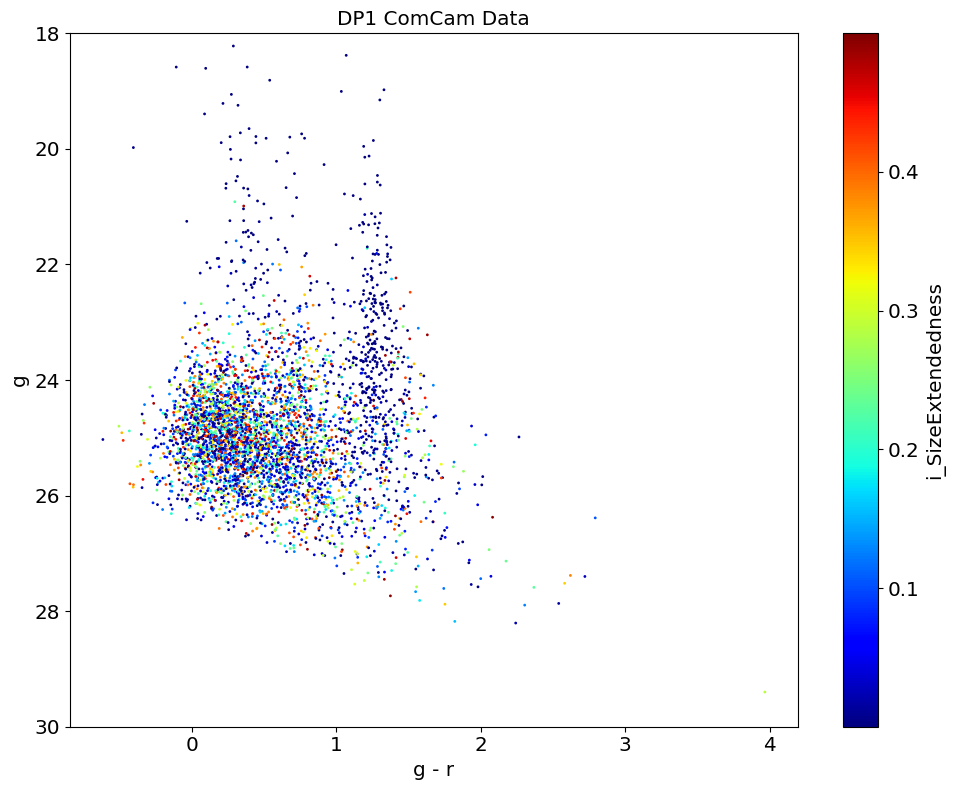

In [11]:
vis_mag = (euclid_field["FLUX_VIS_PSF"] * u.uJy).to(u.ABmag)

lsst_i_mag = flux2mag(lsst_field["i_psfFlux"].values)
lsst_i_mag_cmodel = flux2mag(lsst_field["i_cModelFlux"].values)
lsst_g_mag = flux2mag(lsst_field["g_psfFlux"].values)
lsst_g_mag_cmodel = flux2mag(lsst_field["g_cModelFlux"].values)
lsst_r_mag = flux2mag(lsst_field["r_psfFlux"].values)
lsst_r_mag_cmodel = flux2mag(lsst_field["r_cModelFlux"].values)

#PLOT 1: gaining intuition for what the separation looks like in each band
fig, ax = plt.subplots(4,1, figsize=(10,15))

_=ax[0].scatter(lsst_g_mag,
            lsst_g_mag - lsst_g_mag_cmodel,
            c=lsst_field["g_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="g_SizeExtendedness".lower())
ax[0].set(xlabel='psf mag in g', ylabel='psf - cmodel mag in g',
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[1].scatter(lsst_r_mag,
            lsst_r_mag - lsst_r_mag_cmodel,
            c=lsst_field["r_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="r_SizeExtendedness".lower())
ax[1].set(xlabel='psf mag in r', ylabel='psf - cmodel mag in r',
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[2].scatter(lsst_i_mag,
            lsst_i_mag - lsst_i_mag_cmodel,
            c=lsst_field["i_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="i_SizeExtendedness".lower())
ax[2].set(xlabel='psf mag in i', ylabel='psf - cmodel mag in i',
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[3].scatter(vis_mag,
            euclid_field['MUMAX_MINUS_MAG'],
            c=euclid_field["POINT_LIKE_PROB"],
            s=0.1)
plt.colorbar(_,label="POINT_LIKE_PROB")
ax[3].set(xlabel='FLUX_VIS_PSF',
          ylabel='MUMAX_MINUS_MAG',
          xlim=(15,27.5))
plt.tight_layout()
plt.savefig(my_plotspath + f"photometry_attempt.png")

plt.show()

#PLOT 2: just LSST "stars" (based on i_SizeExtendedness) on color-mag diagram
fig, ax = plt.subplots(1,1, figsize=(10,8))

lsst_g_mag = flux2mag(lsst_stars["g_psfFlux"].values)
lsst_r_mag = flux2mag(lsst_stars["r_psfFlux"].values)

_=ax.scatter(lsst_g_mag - lsst_r_mag,
            lsst_g_mag,
            c=lsst_stars["i_SizeExtendedness"],
            s=1, cmap="jet")
plt.colorbar(_,label="i_SizeExtendedness")
ax.set(xlabel='g - r', ylabel='g',
          ylim = (30, 18), title='DP1 ComCam Data')
plt.tight_layout()
plt.savefig(my_plotspath + f"g_v_gminr.png")

Notes to self:
I seem to have a great number less of sources than Peter in his comcam plot. I don't think we have different cuts at all, except the g_extendedness < 1.0

## Match sources and merge catalogs

Our overall goal is to use Euclid to optimize Rubin's stellar population selection, so we need to match our sources. We can use astropy, but here I'm using ugali (tools created for DES by Alex Drlica-Wagner and Keith Bechtol et al.)

10337 10337


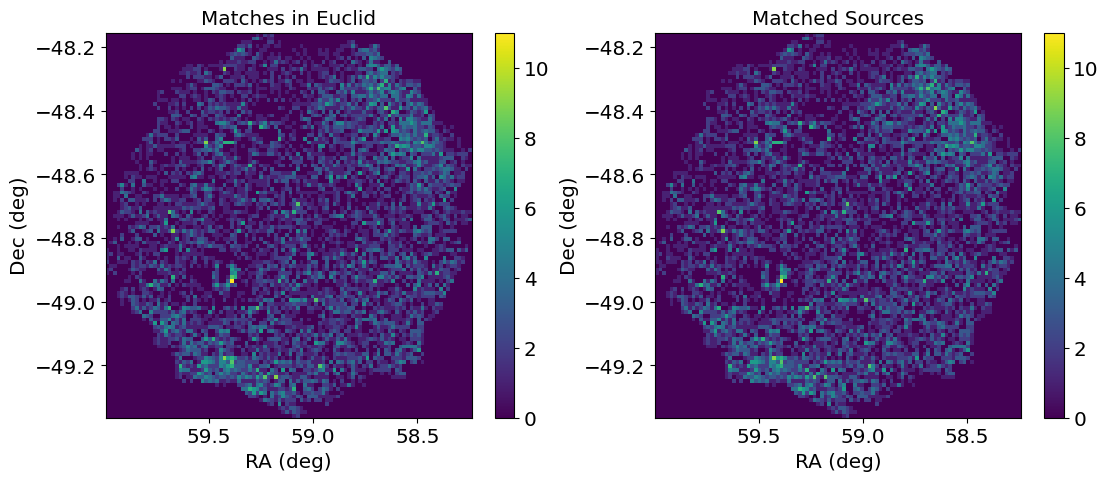

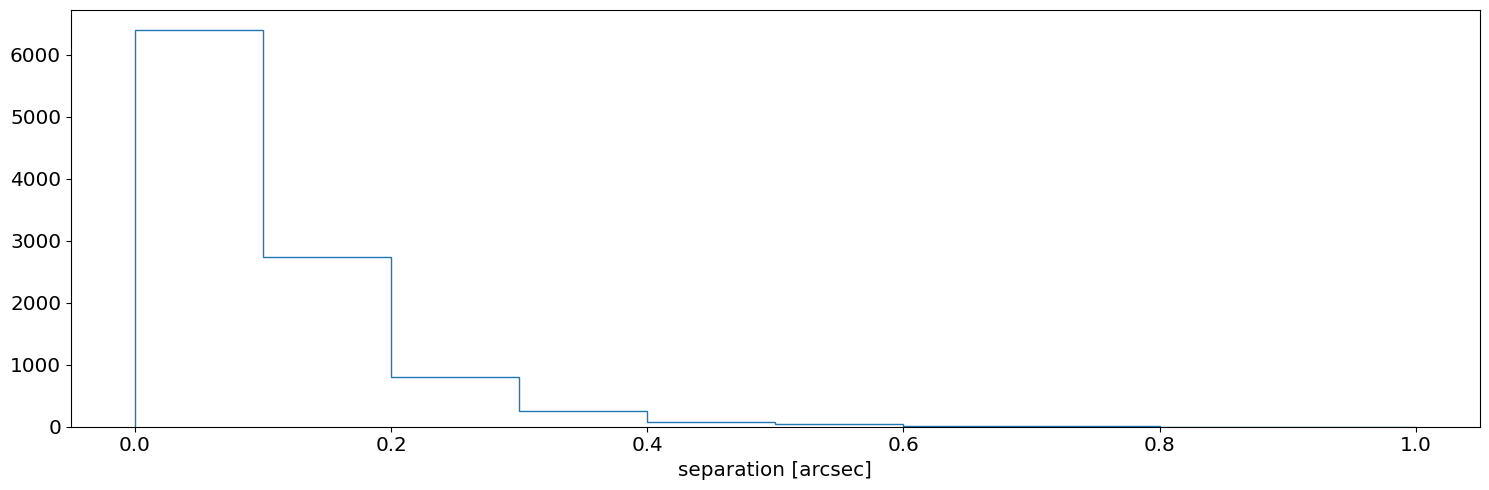

In [12]:
#match() is from ugali tools -- matching LSST and Euclid sources
indexlsst, indexeuclid, ds = match(lsst_ra.values, lsst_dec.values, euclid_ra, euclid_dec, tol = 0.0003)

matches_lsst = lsst_field.to_numpy()[indexlsst]
matches_euclid = euclid_field[indexeuclid]
print(len(matches_lsst), len(matches_euclid))

#Match Verification
fig, ax = plt.subplots(1,2, figsize=(13,5))
_, _, _, im = ax[0].hist2d(matches_euclid['RIGHT_ASCENSION'], matches_euclid['DECLINATION'], bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set(title = 'Matches in Euclid', ylabel = "Dec (deg)", xlabel = "RA (deg)")
ax[0].invert_xaxis()
_, _, _, im = ax[1].hist2d(matches_lsst[:,0], matches_lsst[:,1], bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set(title = 'Matched Sources', ylabel = "Dec (deg)", xlabel = "RA (deg)")
ax[1].invert_xaxis()
plt.show()

ds = ds * 3600 #ds is in degrees, want to plot in arcsecs
#I forced in the function that matches would be <1"
plt.hist(ds, histtype='step', range=(0,1))
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()

14170


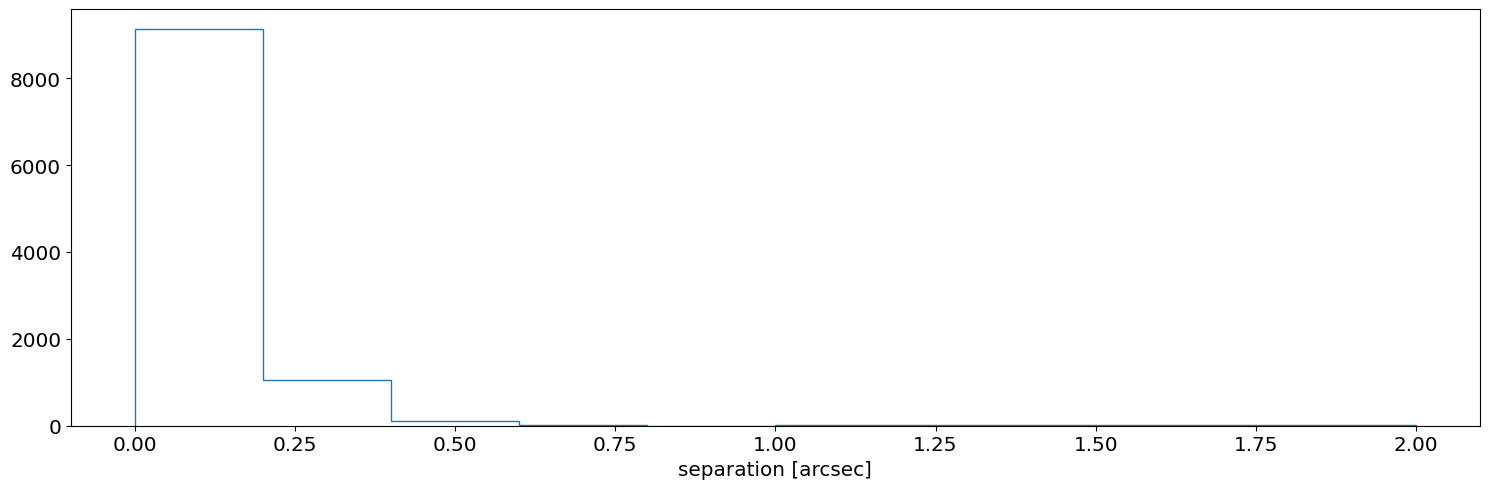

In [13]:
#here I was trying astropy and then deciding to go with ugali bc I couldn't figure out how to enforce a tolerance
lsstSkyCoord = SkyCoord(ra=lsst_ra.values*u.degree, dec=lsst_dec.values*u.degree, frame = 'icrs')
euclidSkyCoord = SkyCoord(ra=euclid_ra*u.degree, dec=euclid_dec*u.degree, frame = 'icrs')
index1, d2d1, d3d1 = lsstSkyCoord.match_to_catalog_sky(euclidSkyCoord)
#index = match index, d2d = distance apart on sky, d3d = 3D distance apart
matches1 = euclid_field[index1]
print(len(matches1))
plt.hist(d2d1.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()

In [14]:
#now merging our matches into one catalog with all LSST and Euclid columns
lsst_df = pd.DataFrame(matches_lsst, columns = lsst_field.columns)
euclid_df = pd.DataFrame(matches_euclid)
merged_df = lsst_df.join(euclid_df)
print(len(lsst_df), len(euclid_df), len(merged_df))

10337 10337 10337


All the dfs are the same length, as expected, but you might find the number of sources plotted when using columns such as POINT_LIKE_PROB or i_SizeExtendedness aren't the same, because some sources have NaN values for these columns

In [15]:
merged_df.to_csv(my_path + 'lsst_euclid_merged.csv')

## Here be dragons (aka old code)

center 140590871
vertices [140786738 140788751 139381481 139365547 140536588 140555018 140647721
 140663289]
field from query [139182058 139182059 139182060 ... 140805201 140805202 140805204]


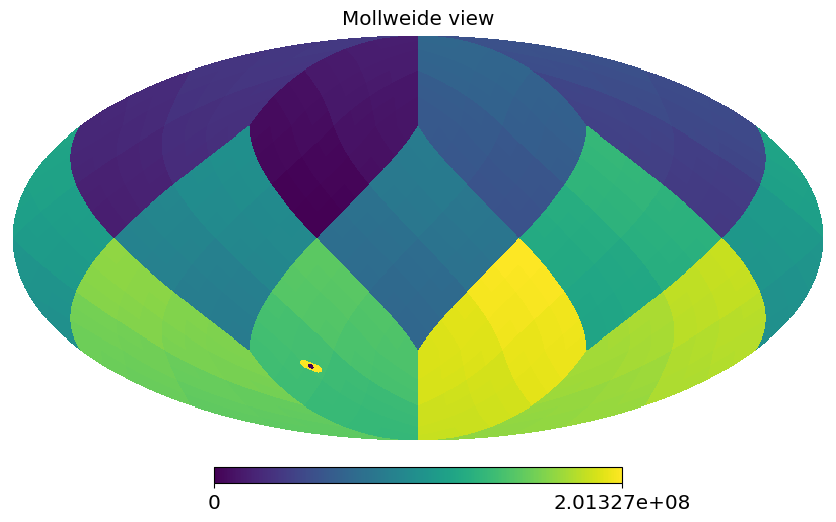

In [16]:
##Learning hp package

NPIX = hp.nside2npix(NSIDE)

center_c = SkyCoord('04:04:57.84', '-48:25:22.8', unit=(u.hourangle, u.deg))
c_RA, c_DEC = center_c.ra.deg, center_c.dec.deg
center_pix = hp.ang2pix(NSIDE, c_RA, c_DEC, lonlat=True, nest=True)

#print(c_RA, c_DEC)

#print(f"NSIDE=64, Nest, HEALPix: {center_pix}")
print('center', center_pix)
vertices = np.array([[63.25, -45.67], [65.35, -46.10], [66.40, -47.25], 
       [65.99, -48.72], [59.25, -51.19], [56.95, -50.82], 
       [55.90, -49.40], [56.80, -47.99]])
#ang2pix(theta, phi)
vert_pix = hp.ang2pix(NSIDE, vertices[:,0], vertices[:,1], lonlat=True, nest=True)
print('vertices', vert_pix)


#ang2vec(lon, lat)
new_vert = hp.ang2vec(vertices[:,0], vertices[:,1], lonlat=True)
edfs = hp.query_polygon(NSIDE, new_vert, inclusive=True, nest=True)
print('field from query', edfs)


new_cen = hp.ang2vec(c_RA, c_DEC, lonlat=True)
circ = hp.query_disc(NSIDE, new_cen, np.radians(1), nest=True)
#print(circ)
m = np.arange(NPIX)
m[edfs] = m.max()
m[circ] = m.min()
hp.mollview(m, nest=True)

In [17]:
"""
outside query
    config['data_dir'] = 'sdf/data/rubin/user/kexcel/software'     # dustmaps
    dustmaps.sfd.fetch()
    sfd = SFDQuery()
in query
    #Define E(B-V) at that position using SFD reddening maps
    R_g = 3.64
    R_r = 2.70
    R_i = 2.06

    E_BV = sfd(coord)

    A_g = R_g *E_BV
    A_r = R_r *E_BV
    A_i = R_i *E_BV
"""
#^ dustmap stuff, maybe add back in eventually
"""
# Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb
    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold =26 
"""
#^ doing this in a different way i think...
"""
can have this syntax: 
        #scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g,
        #scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r,
        #scisql_nanojanskyToAbMagSigma(g_cModelFlux, g_cModelFluxErr) AS magerr_g, 
        #scisql_nanojanskyToAbMagSigma(r_cModelFlux, r_cModelFluxErr) AS magerr_r,
        #scisql_nanojanskyToAbMag(g_cModelFlux) - {A_g} AS mag_corrected_g,     <-- dustmap stuff
        #scisql_nanojanskyToAbMag(r_cModelFlux) - {A_r} AS mag_corrected_r,
"""
#^but since I don't understand it, I'm leaving that out of the query

'\ncan have this syntax: \n        #scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g,\n        #scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r,\n        #scisql_nanojanskyToAbMagSigma(g_cModelFlux, g_cModelFluxErr) AS magerr_g, \n        #scisql_nanojanskyToAbMagSigma(r_cModelFlux, r_cModelFluxErr) AS magerr_r,\n        #scisql_nanojanskyToAbMag(g_cModelFlux) - {A_g} AS mag_corrected_g,     <-- dustmap stuff\n        #scisql_nanojanskyToAbMag(r_cModelFlux) - {A_r} AS mag_corrected_r,\n'

In [18]:
## OLD CODE

'''
Rn I'm thinking the best way is to go pixel by pixel and cut the euclid data that doesn't align with the bounds of the comcam data,
but how to do that??
'''

'''
#gathering the pixels of all the comcam sources, making that a column in the dataframe
comcam_ra1 = raw_comcam1['coord_ra'] 
comcam_dec1 = raw_comcam1['coord_dec']
comcam_pix1 = hp.ang2pix(NSIDE, comcam_ra1, comcam_dec1, lonlat=True, nest=True)
raw_comcam1['hp pix'] = comcam_pix1

comcam_ra2 = raw_comcam2['coord_ra']
comcam_dec2 = raw_comcam2['coord_dec']
comcam_pix2 = hp.ang2pix(NSIDE, comcam_ra2, comcam_dec2, lonlat=True, nest=True)
raw_comcam2['hp pix'] = comcam_pix2

comcam1 = raw_comcam1.to_pandas()
comcam2 = raw_comcam2.to_pandas()
comcam_edfs_total = pd.concat([comcam1[comcam1['hp pix'].isin(list(edfs))], comcam2[comcam2['hp pix'].isin(list(edfs))]])

#combining the two tracts corresponding to comcam's edfs (this is *total*)
print(len(comcam_edfs_total))
type(comcam_edfs_total)
'''

'''
Look at tutorial DP02_03a_Image_Display_and_Manipulation when wanting to do images
Make a cutout rather than whole thing
'''

'\nLook at tutorial DP02_03a_Image_Display_and_Manipulation when wanting to do images\nMake a cutout rather than whole thing\n'